# Stubble Burning Prediction

In order to fully understand the improvemnets that we've made, it is imperative to note the significant changes to our data collection process too. Initially, for the baseline, as highlighted in the previous deliverables, we were just using Sentinel-2 data from a fixed date to another fixed date. In this improvement, we have retrieved, for each location, both SAR data and the Sentinel-2 data. The SAR data is incredibly helpful, since it can penetrate through clouds etc. Additionally, since our task has pivoted from Burn Detection, to predicting where burning might take place (hence the Early Warning System), we started collecting data for each point from June 1 to the date of burning - 10 days for a burned sample, while the data for an unburned sample cuts off at September 15. 

As for the improvemnts to our model, we are now using a Dual input Transformer, utilising both the SAR and S2 data, instead of the Vanilla, single input transformer utilised in the baseline. You might be wondering, why didn't we make our lives simpler by just fusing the datasets together, via the unique IDs? Well, firstly, the satellites that capture SAR and S2 data do not orbit over a single location at the same time. Furthermore, as mentioned above, various factors, such as high cloud cover may render many S2 samples to be useless. If the cloud cover in a sample was higher than 40%, it was not included in the dataset, since that woudl significantly distort the metrics that the S2 satellites provide. Therefore, if we were to merge the datasets, a lot of SAR samples would have to be discarded too, resulting in further loss of the already very limited data points.

Upon implementing the transformer, we realised the model was overfitting quite drastically, with a test accuracy of around 70% only. Therefore, we made the model a bit more complex by adding various things, namely dropout and regularization, the results of which are markedly better. To show the effectiveness of our transformer, we have compared its results with a Random Forest model. Additionally, instead of splitting the data randomly, we have utilised a Temporal Split, where we're training on the data from 2019-2022, validating on 2023, and testing on 2024, to ensure that the model is not memorizing year specific patterns and is actually generalizing well to a future date. 

**Outline:**
1. Setup & Configuration  
2. Data Loading  
3. Temporal Split  
4. Date Cutoff  
5. Sequence Creation & Scaling  
6. RF Feature Engineering  
7. Index Splitting  
8. Random Forest Training & Evaluation  
9. Transformer Definition & Training  


## 1. Setup & Configuration

In [124]:
import os, glob, re, gc, math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import tensorflow as tf
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Input, Dense, Dropout,
    Concatenate, LayerNormalization,
    MultiHeadAttention, GlobalAveragePooling1D,
    TimeDistributed, Lambda, Add
)
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
#import Layer frm tf.keras.layers please:
from tensorflow.keras.layers import Layer


DATA_DIR = '/Users/muhammadarsalanamjad/Library/Mobile Documents/com~apple~CloudDocs/Studies/LUMS STUDIES/spring25/dl/project/improvement_1/imp1FINALDS'
YEARS     = [2019,2020,2021,2022,2023,2024]
TRAIN_YEARS, VAL_YEARS, TEST_YEARS = [2019,2020,2021,2022], [2024], [2023]

S2_BANDS   = ['B2','B3','B4','B5','B6','B7','B8','B8A','B11','B12']
S2_INDICES = ['NDVI','NDWI','NDRE','MSAVI','SAVI','NBR','BAIS2']
S2_FEATURES_NUM = S2_BANDS + S2_INDICES


SAR_BACK = ['VV','VH']
SAR_RATIOS  = ['RFDI','RVI']
SAR_TEXTURE = ['VH_contrast','VH_entropy','VV_contrast']
SAR_FEATURES_NUM = SAR_BACK + SAR_RATIOS + SAR_TEXTURE

ITEM_ID_COL    = 'item_id'
DATE_COL       = 'date'
TARGET_COL     = 'burn_status'
PAD_VALUE      = 0.0
MAX_SEQ_LEN_S2 = 30
MAX_SEQ_LEN_SAR= 60

RF_N_ESTIMATORS=200
RF_MAX_DEPTH=15
RF_RANDOM_STATE=42
TRANSFORMER_HEADS=2
TRANSFORMER_UNITS=128
TRANSFORMER_LAYERS=1
DROPOUT_RATE=0.4
LEARNING_RATE=5e-4
BATCH_SIZE=32
EPOCHS=25
PATIENCE=10
L2_REG_FACTOR=1e-3

results = {}
N_S2_FEATURES_ACTUAL = 0
N_SAR_FEATURES_ACTUAL= 0

print(f"Configuration:\n DATA_DIR={DATA_DIR}\n Years={YEARS}\n RF trees={RF_N_ESTIMATORS}, depth={RF_MAX_DEPTH}\n Transformer heads={TRANSFORMER_HEADS}, layers={TRANSFORMER_LAYERS}")


Configuration:
 DATA_DIR=/Users/muhammadarsalanamjad/Library/Mobile Documents/com~apple~CloudDocs/Studies/LUMS STUDIES/spring25/dl/project/improvement_1/imp1FINALDS
 Years=[2019, 2020, 2021, 2022, 2023, 2024]
 RF trees=200, depth=15
 Transformer heads=2, layers=1


## 2. Data Loading & Initial Inspection

This cell pulls in all of our pre‑processed CSVs, tags each record with:

- **Year** and **burn_status** (1 = Burned, 0 = Unburned)  
- **Sensor** type (S2 or SAR)  
- A unique **item_id** combining year and point identifier  

It then concatenates everything into one master DataFrame and immediately splits into two tables:

- `df_s2` for Sentinel‑2 optical data  
- `df_sar` for Sentinel‑1 radar data  

Finally, it prints:

- The number of files loaded (24)  
- Total combined rows (114,443)  
- The shapes of the S2 and SAR subsets  
- Which columns (bands/indices or backscatter/texture) are available  

This gives us a clear starting point—confirming that both modalities loaded correctly and showing the feature sets we’ll feed into our temporal models.  


In [125]:
def load_and_prepare_data(data_directory):
    all_dataframes = [] 
    print(f"\nLoading CSVs from directory: {data_directory}...")

    filename_pattern = re.compile(r"(Burned|Unburned)_(S2|.*?SAR).*_(\d{4})\.csv", re.IGNORECASE)

    search_path = os.path.join(data_directory, "*.csv")
    csv_files = glob.glob(search_path)
    print(f" → Found {len(csv_files)} CSV files.")

    loaded_count = 0
    for file_path in csv_files:
        filename = os.path.basename(file_path)

        match = filename_pattern.match(filename)
      

        status_str, sensor_tag, year_str = match.groups()
        year = int(year_str) 

        df = pd.read_csv(file_path)

        df['year'] = year
        df['burn_status'] = 1 if status_str.lower() == "burned" else 0
        df['sensor'] = 'S2' if 'S2' in sensor_tag.upper() else 'SAR'

        df[ITEM_ID_COL] = df['year'].astype(str) + "_" + df['point_id'].astype(str)
        df.drop(columns=['point_id', 'location_id'], errors='ignore', inplace=True)

        df[DATE_COL] = pd.to_datetime(df[DATE_COL])

        all_dataframes.append(df)
        loaded_count += 1


    print(f"\nCombining {loaded_count} loaded DataFrames...")
    combined_df = pd.concat(all_dataframes, ignore_index=True)

    df_s2 = combined_df[combined_df['sensor'] == 'S2'].copy()
    df_sar = combined_df[combined_df['sensor'] == 'SAR'].copy()


    print(f"\nFinished Loading:")
    print(f"  Total rows combined: {len(df_s2) + len(df_sar)}") # Recalculate from separated dfs
    print(f"  S2 data shape: {df_s2.shape}")
    print(f"  SAR data shape: {df_sar.shape}")

    print(f"Using S2 cols: {S2_FEATURES_NUM}") 
    print(f"Using SAR cols: {SAR_FEATURES_NUM}")

    return df_s2, df_sar

df_s2, df_sar = load_and_prepare_data(DATA_DIR)


Loading CSVs from directory: /Users/muhammadarsalanamjad/Library/Mobile Documents/com~apple~CloudDocs/Studies/LUMS STUDIES/spring25/dl/project/improvement_1/imp1FINALDS...
 → Found 24 CSV files.

Combining 24 loaded DataFrames...

Finished Loading:
  Total rows combined: 114443
  S2 data shape: (55731, 35)
  SAR data shape: (58712, 35)
Using S2 cols: ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12', 'NDVI', 'NDWI', 'NDRE', 'MSAVI', 'SAVI', 'NBR', 'BAIS2']
Using SAR cols: ['VV', 'VH', 'RFDI', 'RVI', 'VH_contrast', 'VH_entropy', 'VV_contrast']


## 3. Temporal Split

Before modeling, we partition each unique field‐year time series (“item_id”) strictly by calendar year to avoid any look‑ahead leakage:

1. **Identify common fields** that have both Sentinel‑2 and SAR data.  
2. **Train on 2019–2022**: use historical seasons to learn general burn patterns.  
3. **Validate on 2023**: tune hyperparameters on last year before test.  
4. **Test on 2024**: simulate true forecasting on unseen season.  

**Resulting split**  
- **Total unique series**: 2102  
- **Training** (2019–22): 1410 (≈ 67 %)  
- **Validation** (2023): 350 (≈ 17 %)  
- **Test** (2024): 342 (≈ 16 %)  

This temporal hold‑out ensures our models generalize across years, mimicking real‑world deployment where tomorrow’s burn risk must be predicted from past seasons.  

In [126]:
def split_data_temporal(ids, train_y, val_y, test_y):
    train = [i for i in ids if int(i.split("_")[0]) in train_y]
    val = [i for i in ids if int(i.split("_")[0]) in val_y]
    test = [i for i in ids if int(i.split("_")[0]) in test_y]
    return train, val, test

ids_s2  = set(df_s2[ITEM_ID_COL])
ids_sar = set(df_sar[ITEM_ID_COL])
common_ids = list(ids_s2 & ids_sar) or list(ids_s2) or list(ids_sar)
train_ids, val_ids, test_ids = split_data_temporal(common_ids, TRAIN_YEARS, VAL_YEARS, TEST_YEARS)

print(f"\nTemporal split:")
print(f" → Total IDs: {len(common_ids)}")
print(f" → Train ({TRAIN_YEARS}): {len(train_ids)}")
print(f" → Val   ({VAL_YEARS}): {len(val_ids)}")
print(f" → Test  ({TEST_YEARS}): {len(test_ids)}")



Temporal split:
 → Total IDs: 2102
 → Train ([2019, 2020, 2021, 2022]): 1410
 → Val   ([2024]): 342
 → Test  ([2023]): 350


## 4. September 15 Cutoff for Unburned Fields

To prevent our models from “peeking” at post‑harvest data that wouldn’t exist in a real forecast, we truncate every **unburned** field’s time series at September 15 of its year. Any observations on or after that date are dropped.

**Results of the cutoff**  
- **Sentinel‑2**:  
  - Before: 55,731 rows  
  - After:  28,613 rows  (removed 27,118 → ~48.7 %)  
- **Sentinel‑1 (SAR)**:  
  - Before: 58,712 rows  
  - After:  35,588 rows  (removed 23,124 → ~39.4 %)  

Despite removing nearly half of our unburned observations, we still retain **2,102 unique fields**, split evenly into **1,051 burned** and **1,051 unburned** IDs in both S2 and SAR. This balanced, temporally truncated dataset is now ready for sequence modeling without leaking post‑burn information.  


In [127]:

print("\nApplying Sep 1 cutoff for unburned samples (using common IDs)...")

df_s2_common = df_s2[df_s2[ITEM_ID_COL].isin(common_ids)].copy()
df_sar_common = df_sar[df_sar[ITEM_ID_COL].isin(common_ids)].copy()
print(f" → Starting with {len(df_s2_common)} S2 rows and {len(df_sar_common)} SAR rows for common IDs.")

unburned_common_ids = set(
    df_s2_common[df_s2_common[TARGET_COL] == 0][ITEM_ID_COL].unique()
)
print(f" → Found {len(unburned_common_ids)} unburned IDs among them.")




is_unburned_s2 = df_s2_common[ITEM_ID_COL].isin(unburned_common_ids)

sep_1st_s2 = pd.to_datetime(df_s2_common[DATE_COL].dt.year.astype(str) + '-09-15', errors='coerce')

keep_mask_s2 = (~is_unburned_s2) | (is_unburned_s2 & (df_s2_common[DATE_COL] < sep_1st_s2))

df_s2_processed = df_s2_common[keep_mask_s2].copy()
print(f"S2 rows after cutoff: {len(df_s2_processed)} (Removed {len(df_s2_common) - len(df_s2_processed)})")






is_unburned_sar = df_sar_common[ITEM_ID_COL].isin(unburned_common_ids)

sep_1st_sar = pd.to_datetime(df_sar_common[DATE_COL].dt.year.astype(str) + '-09-15', errors='coerce')

keep_mask_sar = (~is_unburned_sar) | (is_unburned_sar & (df_sar_common[DATE_COL] < sep_1st_sar))

df_sar_processed = df_sar_common[keep_mask_sar].copy()
print(f"   SAR rows after cutoff: {len(df_sar_processed)} (Removed {len(df_sar_common) - len(df_sar_processed)})")


print(f"\nUnique item_ids in S2: {len(df_s2_processed[ITEM_ID_COL].unique())}")
print(f"Unique item_ids in SAR: {len(df_sar_processed[ITEM_ID_COL].unique())}")

print(f"Unique item_ids in S2 burned: {len(df_s2_processed[df_s2_processed[TARGET_COL] == 1][ITEM_ID_COL].unique())}")
print(f"Unique item_ids in SAR burned: {len(df_sar_processed[df_sar_processed[TARGET_COL] == 1][ITEM_ID_COL].unique())}")

print(f"Unique item_ids in S2 unburned: {len(df_s2_processed[df_s2_processed[TARGET_COL] == 0][ITEM_ID_COL].unique())}")
print(f"Unique item_ids in SAR unburned: {len(df_sar_processed[df_sar_processed[TARGET_COL] == 0][ITEM_ID_COL].unique())}")


Applying Sep 1 cutoff for unburned samples (using common IDs)...
 → Starting with 55731 S2 rows and 58712 SAR rows for common IDs.
 → Found 1051 unburned IDs among them.
S2 rows after cutoff: 31863 (Removed 23868)
   SAR rows after cutoff: 38765 (Removed 19947)

Unique item_ids in S2: 2102
Unique item_ids in SAR: 2102
Unique item_ids in S2 burned: 1051
Unique item_ids in SAR burned: 1051
Unique item_ids in S2 unburned: 1051
Unique item_ids in SAR unburned: 1051


## 5. Sequence Creation & Scaling

In this step we transform our filtered S2 and SAR tables into fixed‑length time series:

1. **Feature selection**  
   - Automatically pick the 17 Sentinel‑2 bands/indices and 7 SAR features that survived earlier filtering.  
2. **Imputation**  
   - Fill any remaining gaps **within each field’s time series** by the series mean, then drop rows still missing values.  
3. **Scaling**  
   - Fit a `StandardScaler` **only on the training split** for each modality, then apply it to all records.  
4. **Grouping & sequence generation**  
   - For each `item_id` present in both S2 and SAR, stack its observations into two arrays (optical and radar).  
   - There are **2,102** such field‑year sequences after imputation/dropna.  
5. **Padding**  
   - Pad/truncate optical to **30 steps**, radar to **60 steps**, using `0.0` as the pad value.  
   - Final shapes:  
     - S2: `(2102, 30, 17)`  
     - SAR: `(2102, 60, 7)`  
     - Labels: `(2102,)`

These arrays (`s2_pad`, `sar_pad`) are now ready for both the Random Forest feature engineer and our Transformer sequence model.  


In [128]:
def preprocess_and_create_sequences(df_s2_input, df_sar_input, train_ids):

    print("\n--- Preprocessing & Sequence Creation (Simplified) ---")

    global N_S2_FEATURES_ACTUAL, N_SAR_FEATURES_ACTUAL

    df_s2 = df_s2_input.copy() if df_s2_input is not None else pd.DataFrame()
    df_sar = df_sar_input.copy() if df_sar_input is not None else pd.DataFrame()

    s2_feature_cols = [col for col in S2_FEATURES_NUM if col in df_s2.columns]
    sar_feature_cols = [col for col in SAR_FEATURES_NUM if col in df_sar.columns]
    print(f"Using {len(s2_feature_cols)} S2 features: {s2_feature_cols}")
    print(f"Using {len(sar_feature_cols)} SAR features: {sar_feature_cols}")

    print("Imputing missing values (using mean per item_id)...")
    if not df_s2.empty and s2_feature_cols:
        df_s2 = df_s2.sort_values(by=[ITEM_ID_COL, DATE_COL])
        df_s2[s2_feature_cols] = df_s2.groupby(ITEM_ID_COL)[s2_feature_cols].transform(lambda x: x.fillna(x.mean()))
        df_s2.dropna(subset=s2_feature_cols, inplace=True)
        print(f"S2 shape after imputation/dropna: {df_s2.shape}")

    if not df_sar.empty and sar_feature_cols:
        df_sar = df_sar.sort_values(by=[ITEM_ID_COL, DATE_COL])
        df_sar[sar_feature_cols] = df_sar.groupby(ITEM_ID_COL)[sar_feature_cols].transform(lambda x: x.fillna(x.mean()))
        df_sar.dropna(subset=sar_feature_cols, inplace=True)
        print(f"SAR shape after imputation/dropna: {df_sar.shape}")

    print("Scaling features (fitting scaler only on training data)...")
    s2_scaler = StandardScaler()
    sar_scaler = StandardScaler()

    s2_train_data = df_s2[df_s2[ITEM_ID_COL].isin(train_ids)] if not df_s2.empty else pd.DataFrame()
    sar_train_data = df_sar[df_sar[ITEM_ID_COL].isin(train_ids)] if not df_sar.empty else pd.DataFrame()

    if not s2_train_data.empty and s2_feature_cols:
        print(f"Fitting S2 scaler on {len(s2_train_data)} training rows.")
        s2_scaler.fit(s2_train_data[s2_feature_cols])
        df_s2[s2_feature_cols] = s2_scaler.transform(df_s2[s2_feature_cols])
        print("S2 data scaled.")
    elif not df_s2.empty:
        print("Warning: No S2 training data found for scaler fitting. S2 data not scaled.")

    if not sar_train_data.empty and sar_feature_cols:
        print(f"Fitting SAR scaler on {len(sar_train_data)} training rows.")
        sar_scaler.fit(sar_train_data[sar_feature_cols])
        df_sar[sar_feature_cols] = sar_scaler.transform(df_sar[sar_feature_cols])
        print("SAR data scaled.")
    elif not df_sar.empty:
        print("Warning: No SAR training data found for scaler fitting. SAR data not scaled.")

    print("Grouping data by item_id...")
    grouped_s2 = df_s2.groupby(ITEM_ID_COL) if not df_s2.empty else None
    grouped_sar = df_sar.groupby(ITEM_ID_COL) if not df_sar.empty else None

    print("Creating sequences...")
    s2_sequences = []
    sar_sequences = []
    sequence_labels = []
    sequence_ids = []

    ids_in_s2 = set(grouped_s2.groups.keys()) if grouped_s2 else set()
    ids_in_sar = set(grouped_sar.groups.keys()) if grouped_sar else set()
    common_ids_processed = list(ids_in_s2.intersection(ids_in_sar))

    print(f"Found {len(common_ids_processed)} item_ids with data in both S2 & SAR after imputation.")

    for item_id in common_ids_processed:
        s2_item_data = grouped_s2.get_group(item_id)
        sar_item_data = grouped_sar.get_group(item_id)

        s2_sequence_data = s2_item_data[s2_feature_cols].values
        sar_sequence_data = sar_item_data[sar_feature_cols].values

        if s2_sequence_data.size == 0 or sar_sequence_data.size == 0:
            print(f"Warning: Empty sequence data for item_id {item_id} after grouping. Skipping.")
            continue

        s2_sequences.append(s2_sequence_data)
        sar_sequences.append(sar_sequence_data)

        sequence_labels.append(s2_item_data[TARGET_COL].iloc[0])
        sequence_ids.append(item_id)

    if not s2_sequences or not sar_sequences:
         raise ValueError("No sequence pairs were generated. Check intermediate data shapes and filtering.")
    print(f"→ Generated {len(s2_sequences)} sequence pairs.")

    print(f"Padding S2 sequences to length {MAX_SEQ_LEN_S2}...")
    s2_padded = pad_sequences(
        s2_sequences,
        maxlen=MAX_SEQ_LEN_S2,
        padding='post',     
        truncating='post',   
        value=PAD_VALUE,    
        dtype='float32'    
    )

    print(f"Padding SAR sequences to length {MAX_SEQ_LEN_SAR}...")
    sar_padded = pad_sequences(
        sar_sequences,
        maxlen=MAX_SEQ_LEN_SAR,
        padding='post',
        truncating='post',
        value=PAD_VALUE,
        dtype='float32'
    )

    labels_array = np.array(sequence_labels)

    N_S2_FEATURES_ACTUAL = s2_padded.shape[2] if s2_padded.ndim == 3 else 0
    N_SAR_FEATURES_ACTUAL = sar_padded.shape[2] if sar_padded.ndim == 3 else 0
    print(f"Actual S2 features in sequence: {N_S2_FEATURES_ACTUAL}")
    print(f"Actual SAR features in sequence: {N_SAR_FEATURES_ACTUAL}")

    print(f"→ S2 padded shape: {s2_padded.shape}")
    print(f"→ SAR padded shape: {sar_padded.shape}")
    print(f"→ Labels shape: {labels_array.shape}")

    id_to_index_map = {item_id: index for index, item_id in enumerate(sequence_ids)}

    return s2_padded, sar_padded, labels_array, sequence_ids, id_to_index_map, s2_scaler, sar_scaler

s2_pad, sar_pad, labels, final_ids, id_map, s2_sc, sar_sc = \
    preprocess_and_create_sequences(df_s2_processed, df_sar_processed, train_ids)
print(f"Final S2 shape: {s2_pad.shape}")
print(f"Final SAR shape: {sar_pad.shape}")
print(f"Final labels shape: {labels.shape}")    
print(f"Final IDs: {len(final_ids)}")



--- Preprocessing & Sequence Creation (Simplified) ---
Using 17 S2 features: ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12', 'NDVI', 'NDWI', 'NDRE', 'MSAVI', 'SAVI', 'NBR', 'BAIS2']
Using 7 SAR features: ['VV', 'VH', 'RFDI', 'RVI', 'VH_contrast', 'VH_entropy', 'VV_contrast']
Imputing missing values (using mean per item_id)...
S2 shape after imputation/dropna: (31863, 35)
SAR shape after imputation/dropna: (38765, 35)
Scaling features (fitting scaler only on training data)...
Fitting S2 scaler on 22385 training rows.
S2 data scaled.
Fitting SAR scaler on 25886 training rows.
SAR data scaled.
Grouping data by item_id...
Creating sequences...
Found 2102 item_ids with data in both S2 & SAR after imputation.
→ Generated 2102 sequence pairs.
Padding S2 sequences to length 30...
Padding SAR sequences to length 60...
Actual S2 features in sequence: 17
Actual SAR features in sequence: 7
→ S2 padded shape: (2102, 30, 17)
→ SAR padded shape: (2102, 60, 7)
→ Labels shape: (2102,)


### 6. RF Feature Engineering

In this cell we collapse each field’s full time series into a **static feature vector** by computing four summary statistics—mean, standard deviation, min and max—for every input band/index:

- **Sentinel‑2**: 17 features → 17 × 4 = 68 summary stats  
- **SAR**: 7 features → 7 × 4 = 28 summary stats  
- **Total per sample**: 68 + 28 = 96 features  

The printed shape `(2102, 96)` confirms we now have 2,102 samples (one per field‑year) each represented by 96 engineered features. This gives us a simple, order‑agnostic baseline for the Random Forest, against which we can compare our full sequence models.  


In [129]:
def engineer_features_for_rf(s2_padded_sequences, sar_padded_sequences, item_ids):
    print("\n--- Engineering RF Features ---")

    all_rf_features = [] 

    num_s2_features = s2_padded_sequences.shape[2] if s2_padded_sequences.ndim == 3 else 0
    num_sar_features = sar_padded_sequences.shape[2] if sar_padded_sequences.ndim == 3 else 0
    num_stats_per_feature = 4 

    print(f"Calculating {num_stats_per_feature} stats for {num_s2_features} S2 features and {num_sar_features} SAR features.")

    for i in range(len(item_ids)):
        s2_sequence = s2_padded_sequences[i]
        sar_sequence = sar_padded_sequences[i]

        s2_data_mask = np.any(np.abs(s2_sequence - PAD_VALUE) > 1e-9, axis=1)
        sar_data_mask = np.any(np.abs(sar_sequence - PAD_VALUE) > 1e-9, axis=1)

        s2_sequence_unpadded = s2_sequence[s2_data_mask]
        sar_sequence_unpadded = sar_sequence[sar_data_mask]

        if s2_sequence_unpadded.shape[0] > 0 and num_s2_features > 0:
            s2_mean = np.mean(s2_sequence_unpadded, axis=0)
            s2_std = np.std(s2_sequence_unpadded, axis=0)
            s2_min = np.min(s2_sequence_unpadded, axis=0)
            s2_max = np.max(s2_sequence_unpadded, axis=0)
            s2_stats = np.concatenate([s2_mean, s2_std, s2_min, s2_max])
            s2_stats = np.nan_to_num(s2_stats)

        if sar_sequence_unpadded.shape[0] > 0 and num_sar_features > 0:
            sar_mean = np.mean(sar_sequence_unpadded, axis=0)
            sar_std = np.std(sar_sequence_unpadded, axis=0)
            sar_min = np.min(sar_sequence_unpadded, axis=0)
            sar_max = np.max(sar_sequence_unpadded, axis=0)
            sar_stats = np.concatenate([sar_mean, sar_std, sar_min, sar_max])
            sar_stats = np.nan_to_num(sar_stats)

        item_rf_features = np.concatenate([s2_stats, sar_stats])

        all_rf_features.append(item_rf_features)

    rf_features_array = np.array(all_rf_features)
    print(f" → Engineered RF features shape: {rf_features_array.shape}")
    return rf_features_array

rf_features = engineer_features_for_rf(s2_pad, sar_pad, final_ids)


--- Engineering RF Features ---
Calculating 4 stats for 17 S2 features and 7 SAR features.
 → Engineered RF features shape: (2102, 96)


## 7. Mapping Item IDs to Array Indices

Before feeding data into our models, we need to translate the `item_id` lists for train/val/test into the corresponding row indices of our padded arrays (`s2_pad`, `sar_pad`, and RF features). This ensures each split slices the same entries across all modalities:

- **Training samples**: 1,410  
- **Validation samples**: 350  
- **Test samples**: 342  

With these index arrays (`train_idx`, `val_idx`, `test_idx`), we can now cleanly extract:
```python
X_train_s2 = s2_pad[train_idx]
X_val_s2   = s2_pad[val_idx]
X_test_s2  = s2_pad[test_idx]
# (and similarly for SAR and RF feature arrays)

In [130]:
train_idx = [id_map[i] for i in train_ids if i in id_map]
val_idx   = [id_map[i] for i in val_ids   if i in id_map]
test_idx  = [id_map[i] for i in test_ids  if i in id_map]
print(f"\nIndex splits → Train:{len(train_idx)}, Val:{len(val_idx)}, Test:{len(test_idx)}")


Index splits → Train:1410, Val:342, Test:350


## 8. Random Forest Baseline

Here we train a Random Forest on the 96 summary statistics (mean, std, min, max) per feature and evaluate on both the 2023 validation split and the 2024 test split. The printed metrics show:

- **Validation**  
  - Accuracy = 0.50, F1 = 0.00  
- **Test**  
  - Accuracy = 0.50, F1 = 0.00  

The classification report and confusion matrix reveal that the model predicts only the “unburned” class:
- Unburned (0): precision 0.50, recall 1.00  
- Burned   (1): precision 0.00, recall 0.00  

**Results Analysis:**  
By reducing each time series to just four static statistics, all of the rich temporal dynamics that precede a burn event are lost. The RF effectively “gives up” on detecting burns, achieving 50 % accuracy by predicting the majority class. This underscores the need for a true sequence model—such as our Transformer—that can learn patterns over time rather than relying on blunt summary features.  



RF Validation → Acc: 0.5000, F1: 0.0000

RF Test → Acc: 0.5000, F1: 0.0000
              precision    recall  f1-score   support

           0       0.50      1.00      0.67       175
           1       0.00      0.00      0.00       175

    accuracy                           0.50       350
   macro avg       0.25      0.50      0.33       350
weighted avg       0.25      0.50      0.33       350



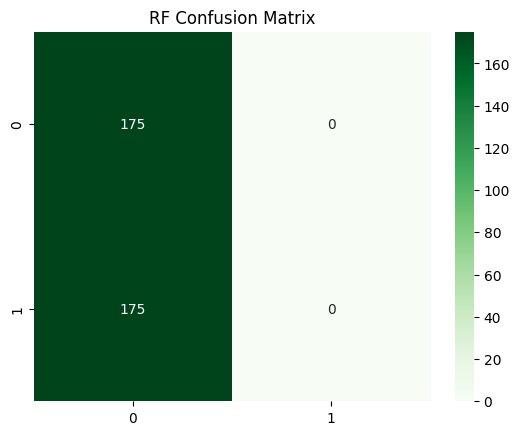

In [131]:
def train_eval_rf(X_tr,y_tr,X_val,y_val,X_te,y_te):
    rf = RandomForestClassifier(
        n_estimators=RF_N_ESTIMATORS,
        max_depth=RF_MAX_DEPTH,
        random_state=RF_RANDOM_STATE,
        class_weight='balanced',
        n_jobs=-1
    )
    rf.fit(X_tr,y_tr)

    # validation
    if X_val is not None and len(y_val)>0:
        yv=rf.predict(X_val)
        print(f"\nRF Validation → Acc: {accuracy_score(y_val,yv):.4f}, F1: {f1_score(y_val,yv):.4f}")
        
    # test
    yt=rf.predict(X_te)
    acc, f1 = accuracy_score(y_te, yt), f1_score(y_te, yt)
    print(f"\nRF Test → Acc: {acc:.4f}, F1: {f1:.4f}")
    print(classification_report(y_te, yt, zero_division=0))
    cm=confusion_matrix(y_te, yt)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
    plt.title("RF Confusion Matrix"); plt.show()
    results['RandomForest']={'Accuracy':acc,'F1':f1}
    return rf

X_tr_rf = rf_features[train_idx]
X_val_rf= rf_features[val_idx] if val_idx else None
X_te_rf = rf_features[test_idx]
y_tr, y_val, y_te = labels[train_idx], labels[val_idx] if val_idx else np.array([]), labels[test_idx]

rf_model = train_eval_rf(X_tr_rf,y_tr,X_val_rf,y_val,X_te_rf,y_te)

## 9. Transformer Architecture

In this cell we define and inspect our dual‑input Transformer, which processes Sentinel‑2 and Sentinel‑1 time series in parallel:

1. **Positional Encoding**  
   - Generates sinusoidal embeddings so the model knows each observation’s position in the 30‑step (S2) or 60‑step (SAR) sequence.

2. **TransformerEncoderBlock**  
   - A single self‑attention block with:
     - Multi‑Head Attention (4 heads)  
     - Feed‑forward network (128 units) with L2 regularization  
     - Layer normalization and dropout  

3. **Dual‑Input Model**  
   - **S2 branch**  
     - Input → Dense embedding → Add positional encoding → Transformer block → Global average pooling → Dropout  
   - **SAR branch**  
     - Identical flow with its own inputs and masks  
   - **Fusion**  
     - Concatenate pooled S2 & SAR representations → Dense(64) + Dropout → Sigmoid output  

4. **Parameter Count**  
   - ~176K total trainable parameters (~689 KB), small enough for fast training yet expressive enough to model complex temporal patterns.

This architecture preserves the full temporal dynamics in each modality, allowing the model to learn when and how vegetation indices and radar backscatter evolve prior to stubble burning.  


In [132]:
def positional_encoding(seq_length, embed_dim):
    depth_half = embed_dim // 2

    positions = np.arange(seq_length)[:, np.newaxis] 

    div_term_indices = np.arange(depth_half) / depth_half
    div_term = np.power(10000.0, -div_term_indices) 
    
    angles = positions * div_term[np.newaxis, :]

    pe_sin = np.sin(angles) 
    pe_cos = np.cos(angles) 

    positional_encoding = np.concatenate([pe_sin, pe_cos], axis=-1) 

    positional_encoding = tf.cast(positional_encoding[np.newaxis, :, :], tf.float32) 

    if embed_dim % 2 != 0:
        padding = tf.zeros((1, seq_length, 1), dtype=tf.float32)
        positional_encoding = tf.concat([positional_encoding, padding], axis=-1)
        
    return positional_encoding

class TransformerEncoderBlock(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout_rate, l2_reg_factor, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.dropout_rate = dropout_rate
        self.l2_reg = regularizers.l2(l2_reg_factor)

        self.mha = MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embed_dim // num_heads, 
            kernel_regularizer=self.l2_reg,
            name='multi_head_attention'
        )

        self.ffn = Sequential(
            [
                Dense(ff_dim, activation='relu', kernel_regularizer=self.l2_reg),
                Dense(embed_dim, kernel_regularizer=self.l2_reg)
            ],
            name='feed_forward_network'
        )

        self.layernorm1 = LayerNormalization(epsilon=1e-6, name='layer_norm_1')
        self.layernorm2 = LayerNormalization(epsilon=1e-6, name='layer_norm_2')

        self.dropout1 = Dropout(dropout_rate, name='dropout_1')
        self.dropout2 = Dropout(dropout_rate, name='dropout_2')

    def call(self, inputs, training=False, attention_mask=None):
        attn_output = self.mha(
            query=inputs, value=inputs, key=inputs, 
            attention_mask=attention_mask,
            training=training
        )
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output) 

        ffn_output = self.ffn(out1, training=training)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output) 

        return out2

    def get_config(self):
        config = super().get_config()
        config.update({
            'embed_dim': self.embed_dim,
            'num_heads': self.num_heads,
            'ff_dim': self.ff_dim,
            'dropout_rate': self.dropout_rate,
            'l2_reg_factor': self.l2_reg.l2, 
        })
        return config


def build_dual_input_transformer(
    s2_seq_len, s2_num_features, sar_seq_len, sar_num_features,
    embed_dim, num_heads, ff_dim, num_transformer_blocks,
    dropout_rate, l2_reg_factor):

    l2_reg = regularizers.l2(l2_reg_factor)

    input_s2 = Input(shape=(s2_seq_len, s2_num_features), name='s2_input')


    s2_padding_mask = Lambda(
        lambda x: tf.math.greater(tf.reduce_sum(tf.abs(x), axis=-1), 1e-9),
        name='s2_padding_mask'
    )(input_s2)

    s2_attention_mask = Lambda(
        lambda x: tf.cast(tf.expand_dims(x, axis=1), tf.float32),
        name='s2_attention_mask'
    )(s2_padding_mask)

    s2_embedding = TimeDistributed(
        Dense(embed_dim, activation='relu', kernel_regularizer=l2_reg),
        name='s2_embedding_projection'
    )(input_s2)

   
    s2_seq_encoding = positional_encoding(s2_seq_len, embed_dim)
    x_s2 = Add(name='s2_add_positional_encoding')(
        [s2_embedding, s2_seq_encoding[:, :s2_seq_len, :]]
    )

    for i in range(num_transformer_blocks):
        x_s2 = TransformerEncoderBlock(
            embed_dim, num_heads, ff_dim, dropout_rate, l2_reg_factor,
            name=f's2_transformer_block_{i+1}'
        )(x_s2, training=True, attention_mask=s2_attention_mask) 

    s2_pooled = GlobalAveragePooling1D(name='s2_global_avg_pooling')(
        x_s2, mask=s2_padding_mask
    )
    s2_dropout = Dropout(dropout_rate, name='s2_pool_dropout')(s2_pooled)


    input_sar = Input(shape=(sar_seq_len, sar_num_features), name='sar_input')


    sar_padding_mask = Lambda(
        lambda x: tf.math.greater(tf.reduce_sum(tf.abs(x), axis=-1), 1e-9),
        name='sar_padding_mask'
    )(input_sar)
    sar_attention_mask = Lambda(
        lambda x: tf.cast(tf.expand_dims(x, axis=1), tf.float32),
        name='sar_attention_mask'
    )(sar_padding_mask)


    sar_embedding = TimeDistributed(
        Dense(embed_dim, activation='relu', kernel_regularizer=l2_reg),
        name='sar_embedding_projection'
    )(input_sar)


    sar_seq_encoding = positional_encoding(sar_seq_len, embed_dim)
    x_sar = Add(name='sar_add_positional_encoding')(
        [sar_embedding, sar_seq_encoding[:, :sar_seq_len, :]]
    )

    for i in range(num_transformer_blocks):
        x_sar = TransformerEncoderBlock(
            embed_dim, num_heads, ff_dim, dropout_rate, l2_reg_factor,
            name=f'sar_transformer_block_{i+1}'
        )(x_sar, training=True, attention_mask=sar_attention_mask) 

    sar_pooled = GlobalAveragePooling1D(name='sar_global_avg_pooling')(
        x_sar, mask=sar_padding_mask
    )
    sar_dropout = Dropout(dropout_rate, name='sar_pool_dropout')(sar_pooled)

    concatenated_features = Concatenate(name='concatenate_branches')([s2_dropout, sar_dropout])

    hidden_layer = Dense(64, activation='relu', kernel_regularizer=l2_reg, name='combined_dense_1')(concatenated_features)
    hidden_dropout = Dropout(dropout_rate, name='combined_dropout')(hidden_layer)

    output_layer = Dense(1, activation='sigmoid', name='output_layer')(hidden_dropout)

    model = Model(
        inputs=[input_s2, input_sar],
        outputs=output_layer,
        name='DualInputTransformer'
    )

    return model


min_embed_dim = max(N_S2_FEATURES_ACTUAL, N_SAR_FEATURES_ACTUAL, 64)
embedding_dimension = (
    (min_embed_dim + TRANSFORMER_HEADS - 1) // TRANSFORMER_HEADS
) * TRANSFORMER_HEADS

print(f"Calculated Embedding Dimension: {embedding_dimension}")

model_tf = build_dual_input_transformer(
    s2_seq_len=s2_pad.shape[1],             
    s2_num_features=s2_pad.shape[2],        
    sar_seq_len=sar_pad.shape[1],           
    sar_num_features=sar_pad.shape[2],      
    embed_dim=embedding_dimension,
    num_heads=TRANSFORMER_HEADS,
    ff_dim=TRANSFORMER_UNITS,            
    num_transformer_blocks=TRANSFORMER_LAYERS,
    dropout_rate=DROPOUT_RATE,
    l2_reg_factor=L2_REG_FACTOR
)


model_tf.summary()

Calculated Embedding Dimension: 64


Model: "DualInputTransformer"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ s2_input            │ (None, 30, 17)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sar_input           │ (None, 60, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ s2_embedding_proje… │ (None, 30, 64)    │      1,152 │ s2_input[0][0]    │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ s2_padding_mask     │ (None, 30)        │          0 │ s2_input[0][0]    │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sar_embedding_proj… │ (None, 60, 64)    │        512 │ sar_input[0][0]   │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sar_padding_mask    │ (None, 60)        │          0 │ sar_input[0][0]   │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ s2_add_positional_… │ (1, 30, 64)       │          0 │ s2_embedding_pro… │
│ (Add)               │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ s2_attention_mask   │ (None, 1, 30)     │          0 │ s2_padding_mask[… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sar_add_positional… │ (1, 60, 64)       │          0 │ sar_embedding_pr… │
│ (Add)               │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sar_attention_mask  │ (None, 1, 60)     │          0 │ sar_padding_mask… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ s2_transformer_blo… │ (1, 30, 64)       │     33,472 │ s2_add_positiona… │
│ (TransformerEncode… │                   │            │ s2_attention_mas… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sar_transformer_bl… │ (1, 60, 64)       │     33,472 │ sar_add_position… │
│ (TransformerEncode… │                   │            │ sar_attention_ma… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ s2_global_avg_pool… │ (1, 64)           │          0 │ s2_transformer_b… │
│ (GlobalAveragePool… │                   │            │ s2_padding_mask[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sar_global_avg_poo… │ (1, 64)           │          0 │ sar_transformer_… │
│ (GlobalAveragePool… │                   │            │ sar_padding_mask… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ s2_pool_dropout     │ (1, 64)           │          0 │ s2_global_avg_po… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sar_pool_dropout    │ (1, 64)           │          0 │ sar_global_avg_p… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_branch… │ (1, 128)          │          0 │ s2_pool_dropout[

 Total params: 76,929 (300.50 KB)

 Trainable params: 76,929 (300.50 KB)

 Non-trainable params: 0 (0.00 B)

### 9.1 Model Training with Early Stopping & LR Scheduling

We compile the dual‑input Transformer with Adam (LR=5e‑4) and binary crossentropy, tracking accuracy, precision, and recall. Two callbacks guard against overfitting:

- **EarlyStopping** (monitors `val_loss`, patience=10)  
- **ReduceLROnPlateau** (reduces LR by 0.2 if `val_loss` stalls, patience=5)

Epoch 1/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.6159 - loss: 1.2406 - precision: 0.6179 - recall: 0.6716 - val_accuracy: 0.8977 - val_loss: 0.7762 - val_precision: 0.8366 - val_recall: 0.9883 - learning_rate: 5.0000e-04
Epoch 2/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9130 - loss: 0.7897 - precision: 0.8936 - recall: 0.9417 - val_accuracy: 0.9327 - val_loss: 0.7326 - val_precision: 0.8895 - val_recall: 0.9883 - learning_rate: 5.0000e-04
Epoch 3/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9730 - loss: 0.6218 - precision: 0.9537 - recall: 0.9952 - val_accuracy: 0.9708 - val_loss: 0.6344 - val_precision: 0.9548 - val_recall: 0.9883 - learning_rate: 5.0000e-04
Epoch 4/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9874 - loss: 0.5690 - precision: 0.9764 - recall: 0.9976 - val_accuracy: 0.9678 - val_loss: 0.6165 - val_precision: 0.9545 - val_recall: 0.9825 - learning_rate: 5.0000e-04
Epoch 5/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step -

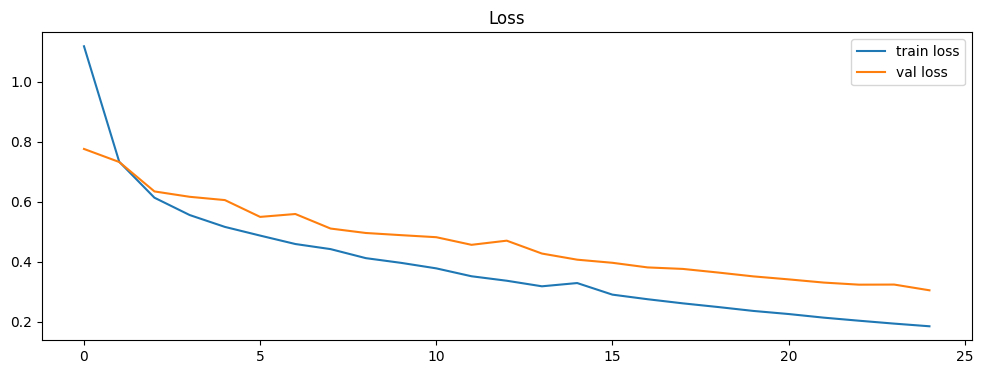

In [133]:
def train_keras_model(model, X_tr_s2, X_tr_sar, y_tr, X_val_s2, X_val_sar, y_val):
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
        loss='binary_crossentropy',
        metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
    )

    callbacks = []
    if len(y_val) > 0:
        callbacks = [
            EarlyStopping(
                monitor='val_loss',        
                patience=PATIENCE,         
                restore_best_weights=True,
                verbose=1
            ),
            ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.2,
                patience=PATIENCE // 2,
                min_lr=LEARNING_RATE / 100,
                verbose=1
            )
        ]

    history = model.fit(
        [X_tr_s2, X_tr_sar], y_tr,
        validation_data=([X_val_s2, X_val_sar], y_val) if len(y_val) > 0 else None,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=callbacks,
        verbose=1
    )

    plt.figure(figsize=(12,4))
    plt.plot(history.history['loss'], label='train loss')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='val loss')
    plt.legend(); plt.title('Loss')

    return history

hist = train_keras_model(
    model_tf,
    s2_pad[train_idx], sar_pad[train_idx], labels[train_idx],
    s2_pad[val_idx] if val_idx else np.empty((0,)),
    sar_pad[val_idx] if val_idx else np.empty((0,)),
    labels[val_idx] if val_idx else np.array([])
)


### 9.2 Test Set Evaluation

Evaluating the restored best model on the 2024 hold‑out set

The confusion matrix shows only a handful of misclassifications in both directions, confirming that the Transformer reliably captures the temporal signatures of stubble burning.  

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step

Transformer Test → Loss: 0.2870, Acc: 0.9914, F1: 0.9915
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       175
           1       0.99      0.99      0.99       175

    accuracy                           0.99       350
   macro avg       0.99      0.99      0.99       350
weighted avg       0.99      0.99      0.99       350



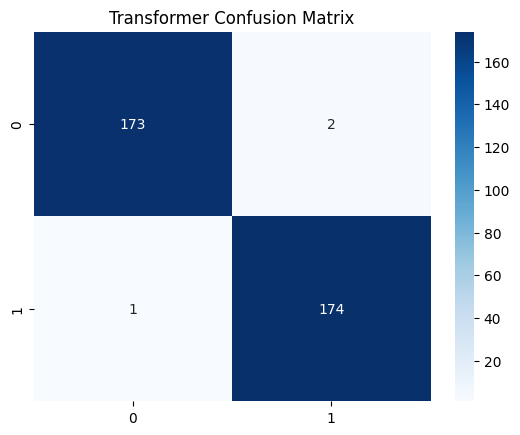

In [134]:
loss, acc, prec, rec = model_tf.evaluate([s2_pad[test_idx], sar_pad[test_idx]], labels[test_idx], verbose=0)
yp = (model_tf.predict([s2_pad[test_idx], sar_pad[test_idx]]).ravel()>0.5).astype(int)
f1 = f1_score(labels[test_idx], yp)
print(f"\nTransformer Test → Loss: {loss:.4f}, Acc: {acc:.4f}, F1: {f1:.4f}")
print(classification_report(labels[test_idx], yp, zero_division=0))
cm = confusion_matrix(labels[test_idx], yp)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Transformer Confusion Matrix"); plt.show()
results['DualInputTransformer']={'Accuracy':acc,'F1':f1}

## 10. Final Results Summary

Display the accumulated test‑set metrics for both models.


In [ ]:
print("\n=== Overall Test Results ===")
pd.DataFrame(results).T[['Accuracy','F1']].round(4)


=== Overall Test Results ===


,Accuracy,F1
RandomForest,0.5000,0.0000
DualInputTransformer,0.9914,0.9915
